# Floating point & roundoff error

CPSC 303: Numerical Approximation and Discretization

2018 Winter Term 2

The University of British Columbia

Mike Gelbart

### Announcements

- PS5a due Wednesday March 27 at 11am
- PS4 grades will be released this afternoon

In [1]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 16

In [3]:
%autosave 0

Autosave disabled


In [4]:
# motivating example
0.3 - 0.2 - 0.1 

-2.7755575615628914e-17

(demonstrate this in other languages)

<br><br><br><br><br>

Funny story: during my undergrad I send a bug report to MathWorks because I observed this behaviour in MATLAB. I got a very polite and patient response... 

#### Assumed knowledge

- Binary numbers
- Scientific notation

#### fractional numbers in binary (5 min)

Consider the number $101.11$

Interpretation:

$$\begin{align*}
    &1\times 2^2 \\
+\, &0\times 2^1 \\
+\, &1\times 2^0 \\
+\, &1\times 2^{-1}  \\
+\, &1\times 2^{-2}  \\
\\
=\, &4+1+0.5+0.25 = 5.75
\end{align*}$$

Exercise: convert $110.101$ to base 10.



#### Explain floating point system (20 min)

Everything is represented in "scientific notation". In other words, $A \times 10^B$. Except in this case it's more like $1.M \times 2^E$, where $M$ is called the mantissa and $E$ is called the exponent.

Examples:

| number in base 10  | scientific notation (base 10) | scientific notation (binary) | mantissa (M)  | exponent (E)  | 
|--------------------|-------------------------------|------------------------------|--------|--------|
|  $2.0$               |  $1.0\times 2^1$              |  $1.0 \times 2^1$            | $0$    |  $1$   |
|  $10.0$              |  $1.25\times 2^3$             |  $1.01\times 2^{11}$         | $01$   |  $11$  | 
| $0.375$            |  $1.5\times 2^{-2} $          |  $1.1\times 2^{-10}$         | $1$    |  $-10$ |
| $0.1$              |  $1.6 \times 2^{-4}$          | $1.100110011\ldots \times 2^{-100}$       | $100110011$...   | $-100$ |

- Some numbers that are short in base 10 are (infinitely) long in base 2, like $0.1$.
- We have infinitely long numbers like this in base 10 too, like $1/3$.

[**IEEE floating point standard**](https://en.wikipedia.org/wiki/IEEE_floating_point): 

Key info: in IEEE double precision, we use 53 bits for the mantissa and 11 bits for the exponent (total = 64 bits).

#### some take home messages (!!)

- numbers are not represented exactly
- most calculations are "wrong"
- when these errors are introduced, **you might not get an error message or warning**
- most numbers cannot be represented
- even most _integers_ cannot be represented as floating point numbers
- there is a biggest number
- there is a smallest number
- most environments you'll encounter will use IEEE double precision... but others do exist (especially single precision)

In [5]:
type(100)

int

In [6]:
type(100.0)

float

#### largest possible number


Around $2^{2^{10}}\approx 10^{300}$

#### spacing between numbers (10 min)

Imagine you were in the decimal system (not binary), and were using scientific notation but you were only allowed 3 digits after the decimal point. In-class exercise: how large is the _spacing_ between the given number and the _next largest number that we can represent_?

2. $8.982$
3. $3.432\times 10^2$
4. $0.001\times 10^1$

Conclusion: we only need to look at the exponent. 

The same goes for binary. The steps happen at every power of 2 instead of 10, and we have way more digits after the decimal (52 instead of 3), but everything else is pretty much the same.

So the spacing size, as a function of the number itself, is a staircase function. 


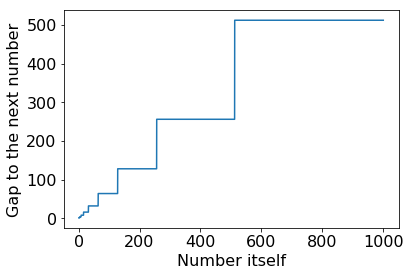

In [7]:
x = np.linspace(1,1000,100000)
spacing = 2**np.floor(np.log2(x))
plt.plot(x, spacing);
plt.xlabel("Number itself");
plt.ylabel("Gap to the next number");

In [8]:
2**-52 # this is the spacing at 1.0

2.220446049250313e-16

The steps get bigger, but the trend is a straight line. In other words, if we zoom out we see that the spacing size is _proportional to the number itself_. 

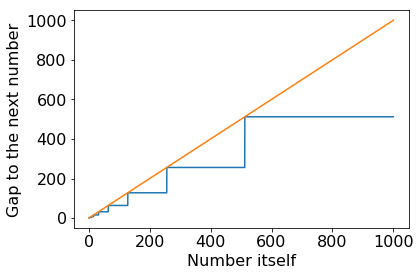

In [9]:
plt.plot(x, spacing)
plt.plot(x,x);
plt.xlabel("Number itself");
plt.ylabel("Gap to the next number");

We can also look on a log-log scale

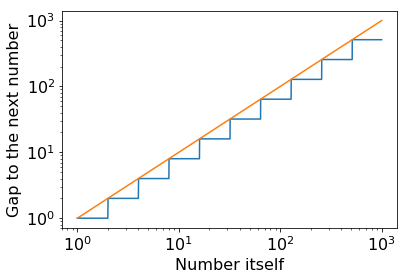

In [10]:
plt.loglog(x,spacing)
plt.loglog(x,x);
plt.xlabel("Number itself");
plt.ylabel("Gap to the next number");

Going back to our original example:

In [11]:
0.3-0.2-0.1

-2.7755575615628914e-17

- Let's assume some rounding occurred at the end, i.e. 52 bits after the decimal point. 
- Then we'd expect things to be wrong on the order of 

In [12]:
2**(-52)*(0.1)

2.2204460492503132e-17

In [13]:
2**-52

2.220446049250313e-16

#### take-home message about roundoff errors

error in representing a number $\approx$ the number itself $\times \, 10^{-16}$

#### Example: order of operations (5 min)

Consider the following:

In [14]:
1e16 + 1 + 1 == 1 + 1 + 1e16

False

????????

Ok... let's break it down.

In [15]:
1 + 1 + 1e16 == 1e16 # makes sense

False

In [19]:
1e16 + 1.5 == 1e16 # ????

False

In [ ]:
1e16 + 1 + 1 +1+1+1+1+1+1+1+1+1 == 1e16

Ok, so the first one is the weird one. We now understand the above, given our new knowledge. The spacing between $10^{16}$ and the next largest number must be more than 2, so when 1 is added to $10^{16}$ we round back down to $10^{16}$.

What's happening here is that we do operations from left to right. So when we first do 1+1 we get 2. And I picked $10^{16}$ on purpose so that the spacing is more than 2 but less than 4. So when we add 2 to $10^{16}$ we do get far enough to round _up_ to the next number. In other words, the order of operations doesn't matter on paper, but it can matter in code due to floating point issues. 

We can check our reasoning by adding on the right side with parentheses

In [20]:
1e16 + (1+1) == 1e16

False

For kicks:

In [21]:
x = 1e16
for i in range(100000):
    x = x + 1
x == 1e16

True

We can make it look even more disturbing for big numbers...

In [22]:
1e40 + 10000000 == 1e40

True

Or small numbers...

In [23]:
1 + 1e-20 == 1

True

Very abbreviated version of this lecture: "you have 16 digits of precision to work with".

(begin bonus) By the way, what _is_ the spacing at $10^{16}$? We need to find the larest power of 2 that is less than $10^{16}$, which happens to be

In [ ]:
2.0**53 

In [ ]:
# make it easier to read
'%g' % 2.0**53

Ok this looks good. So now we just need to do $2^{53}\times 2^{-52}=2$. So the spacing is exactly 2. I guess we round down when we add 1! We can also test this:

In [ ]:
1e16 + 1 == 1e16

In [ ]:
1e16 + 1.0000001 == 1e16

(end bonus)

#### Example: Computing $\log(1+\exp(z))$ (10 min)

- Something like this appears in logistic regression / neural network code
- Intermediate overflows when $z$ is large:

In [24]:
def log_1_plus_exp(z):
    return np.log(1+np.exp(z))

In [25]:
log_1_plus_exp(1000)

/Users/mgelbart/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


inf

But when $z\gg1$ we can say $1+\exp(z)\approx \exp(z)$ and in that case  

$$\log(1+\exp(z))\approx \log(\exp(z)) = z$$

We can try it...

In [26]:
def log_1_plus_exp_safe(z):
    if z > 100:
        return z
    else:
        return np.log(1+np.exp(z))

In [27]:
print(log_1_plus_exp(0))
print(log_1_plus_exp_safe(0))

0.6931471805599453
0.6931471805599453


In [28]:
print(log_1_plus_exp(1000))
print(log_1_plus_exp_safe(1000))

inf
1000


/Users/mgelbart/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [29]:
print(log_1_plus_exp(110.))
print(log_1_plus_exp_safe(110.))

110.0
110.0


What about when $z$ is very negative? Well, when $z\ll -1$ then $\exp(z)$ is very small. Let's define $\epsilon\equiv \exp(z)$. From the Taylor expansion, we have that $\log(1+\epsilon)\approx \epsilon$ for $\epsilon$ very small. So now we can say $\log(1+\exp(z))\approx\exp(z)$ when $z\ll -1$.  So...

In [ ]:
def log_1_plus_exp_safer(z):
    if z > 100:
        return z
    elif z < -10:
        return np.exp(z)
    else:
        return np.log(1+np.exp(z))

In [ ]:
print(log_1_plus_exp(-100))
print(log_1_plus_exp_safe(-100))
print(log_1_plus_exp_safer(-100))

This is cool! By combining an understanding of floating point errors and math, we can write better code.